In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [39]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

In [40]:
nltk.download(['stopwords', 'wordnet'])
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def clean_text(text):

    text = text.lower()

    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs
    #text = re.sub(r"http", "",text)

    html=re.compile(r'<.*?>')

    text = html.sub(r'',text) #Removing html tags

    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations

    text = [word.lower() for word in text.split() if word.lower() not in sw]

    text = [lemmatizer.lemmatize(word) for word in text]

    text = " ".join(text) #removing stopwords and lemmatizing

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
def preprocess(df):
  df['text'] = df['text'].apply(lambda x: clean_text(x))
  df = df.fillna('NaN', axis=1)
  df['text'] = 'KEYWORD= ' + df.keyword + '; LOCATION= ' + df.location + '; TEXT= ' + df.text
  df.drop(["id", "keyword", "location"], inplace=True, axis=1)
  return df

In [42]:
df_train = preprocess(df_train)
df_test = preprocess(df_test)

In [43]:
df_train.isna().sum()

text      0
target    0
dtype: int64

In [44]:
df_train.shape

(7613, 2)

<Axes: >

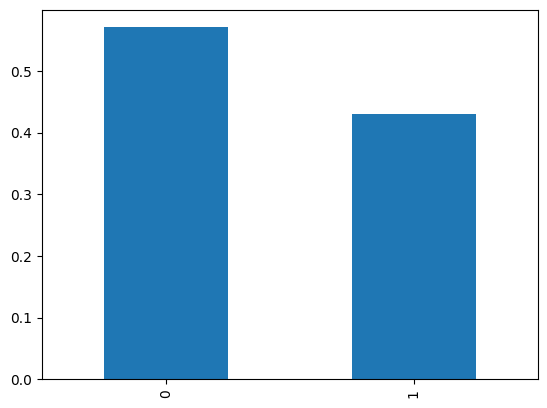

In [45]:
df_train['target'].value_counts(normalize=True).plot.bar()

In [46]:
TRAIN_SPLIT = 0.9
VAL_SPLIT = 0.1

from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]
y=y.astype('int')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [47]:
# Train TFIDF model
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,3))

X_train_cv = tfidf.fit_transform(X_train)

X_train_cv.shape

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(6851, 121322)

In [48]:
y_train

4620    0
2858    1
3098    0
3751    0
5285    1
       ..
5226    0
5390    0
860     0
7603    1
7270    1
Name: target, Length: 6851, dtype: int64

In [49]:
# Training SVM model

from sklearn.svm import SVC

clf = SVC(C=1, kernel='linear',
          decision_function_shape='ovo')
clf.fit(X_train_cv, y_train)

# transform X_val using CV
X_val_cv = tfidf.transform(X_val)

# generate predictions
predictions = clf.predict(X_val_cv)
predictions

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,

In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78       426
           1       0.73      0.73      0.73       336

    accuracy                           0.76       762
   macro avg       0.76      0.76      0.76       762
weighted avg       0.76      0.76      0.76       762



In [51]:
df = pd.DataFrame(confusion_matrix(y_val,predictions), index=[0,1], columns=[0,1])

df

,0,1
0,334,92
1,91,245


In [52]:
f1 = f1_score(y_val, predictions)
f1

0.7280832095096582

In [53]:
# Preparing submission

# transform X_test using CV
X_test_cv = tfidf.transform(X_test)


# generate predictions
predictions = clf.predict(X_test_cv)
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [54]:
predicted_df = df_test.copy()
predicted_df['target'] = predictions

In [55]:
predicted_df

,text,target
0,happened terrible car crash,1
1,"heard earthquake different cities, stay safe e...",1
2,"forest fire spot pond, goose fleeing across st...",1
3,apocalypse lighting spokane wildfire,1
4,typhoon soudelor kill china taiwan,1
...,...,...
3258,earthquake safety los angeles safety fastener ...,1
3259,storm ri worse last hurricane city amp others ...,1
3260,green line derailment chicago http tco utbxlcbiuy,1
3261,meg issue hazardous weather outlook hwo http t...,1


In [37]:
submission_df = pd.read_csv(f'/content/sample_submission.csv')
submission = pd.DataFrame({"id": submission_df['id'],
            "target":predictions})
submission.to_csv('/content/submission.csv', index=False)